In [1]:
import pandas as pd
import nltk
import string, re
import numpy as np
from sklearn.cluster import AgglomerativeClustering

In [2]:
data = pd.read_csv("covid_19_tweets.csv",names= ['OriginalTweet', 'Sentiment'],header=1,encoding = "ISO-8859-1")
data

,OriginalTweet,Sentiment
0,"Due to the Covid-19 situation, we have increas...",Extremely Positive
1,#horningsea is a caring community. LetÂs ALL ...,Extremely Positive
2,"Amazon Glitch Stymies Whole Foods, Fresh Groce...",Extremely Positive
3,with 100 nations inficted with covid 19 th...,Extremely Negative
4,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,Extremely Positive
...,...,...
12099,HMU FOR PRICES!! Got great deals going right n...,Extremely Positive
12100,@MajangChien @MTNSSD @MTNSSD is worst than COV...,Extremely Positive
12101,UV light Sterilizer Sanitizer for your mask an...,Extremely Positive
12102,@MrSilverScott you are definitely my man. I fe...,Extremely Positive


In [3]:
data.groupby(['Sentiment'])['Sentiment'].count()

Sentiment
Extremely Negative    5480
Extremely Positive    6624
Name: Sentiment, dtype: int64

In [4]:
sen = data['Sentiment'].to_list()
ot = data['OriginalTweet'].to_list()
ot

['Due to the Covid-19 situation, we have increased demand for all food products. \r\r\n\r\r\nThe wait time may be longer for all online orders, particularly beef share and freezer packs. \r\r\n\r\r\nWe thank you for your patience during this time.',
 '#horningsea is a caring community. LetÂ\x92s ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolation if you have symptoms or been exposed to somebody who has. https://t.co/lsGrXXhjhh',
 'Amazon Glitch Stymies Whole Foods, Fresh Grocery Deliveries\r\r\nÂ\x93As COVID-19 has spread, weÂ\x92ve seen a significant increase in people shopping online for groceries,Â\x94 a spokeswoman said in a statement. Â\x93Today this resulted in a systems impact affecting our ...\r\r\n https://t.co/TbzZ2MC3b3',
 'with 100  nations inficted with  covid  19  the world must  not  play fair with china  100 goverments must demand  china  adopts new guilde  lines on f

In [5]:
from nltk.tokenize import casual_tokenize
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [6]:
import string, re

def my_tokenizer(text):
    '''
    tokenize
    '''
    text_lower = text.lower()
    tokens = casual_tokenize(text_lower,reduce_len=True,strip_handles=True)
    #tokenizer = TreebankWordTokenizer()
    #tokens = tokenizer.tokenize(text.lower())
    #print(tokens)
    '''
    This is the step to remove tokens which are not needed
    In this example, removing all punctuations and remove stop words
    '''
    
    
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 4]
    tokens = [word for word in tokens if word.isalnum()]
    

    #print(tokens)
    '''
    lemmantization
    '''
    doc = nlp(' '.join(tokens))
    tokens = [word.lemma_ for word in doc]
    
    '''
    removing stop words and punctuation marks again.
    lemmantization may create some of these
    '''
    #tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 4 ]
    tokens = [word for word in tokens if word.isalnum()]
    return tokens



In [37]:
nTweet = data.loc[data['Sentiment']=='Extremely Negative']['OriginalTweet'].to_list()

word_list = [word for line in nTweet for word in line.split()]

processed_word_list = my_tokenizer(' '.join(word_list))

fdist_nTweet = nltk.FreqDist(processed)
fdist_nTweet.most_common(10)


[('price', 1579),
 ('covid', 1548),
 ('people', 1225),
 ('panic', 1185),
 ('supermarket', 1018),
 ('crisis', 838),
 ('store', 836),
 ('grocery', 678),
 ('consumer', 590),
 ('buying', 424)]

In [38]:
pTweet = data.loc[data['Sentiment']=='Extremely Positive']['OriginalTweet'].to_list()

word_list = [word for line in pTweet for word in line.split()]

processed_word_list = my_tokenizer(' '.join(word_list))

fdist_nTweet = nltk.FreqDist(processed)
fdist_nTweet.most_common(10)

[('price', 1579),
 ('covid', 1548),
 ('people', 1225),
 ('panic', 1185),
 ('supermarket', 1018),
 ('crisis', 838),
 ('store', 836),
 ('grocery', 678),
 ('consumer', 590),
 ('buying', 424)]

In [9]:
tweet_sentiment = data['Sentiment']
tweet_text  = data['OriginalTweet']

In [10]:
from sklearn.model_selection import train_test_split
tweet_train, tweet_test, sentiment_train, sentiment_test = train_test_split(tweet_text, tweet_sentiment, test_size=0.2)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

'''
First fit the tfidfvectorizer on the training set
'''

corpus_train=tweet_train.to_list()
vectorizer = TfidfVectorizer(min_df=10,analyzer=my_tokenizer) 
tweet_train_tfidf = vectorizer.fit_transform(corpus_train)
tweet_train_tfidf = tweet_train_tfidf.todense()
print(tweet_train_tfidf.shape)


'''
Use the same  tfidfvectorizer to transform the testing set
'''

corpus_test=tweet_test.to_list()
tweet_test_tfidf = vectorizer.transform(corpus_test)
tweet_test_tfidf = tweet_test_tfidf.todense()
print(tweet_test_tfidf.shape)

(9683, 1587)
(2421, 1587)


In [12]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
tweet_train_tfidf_balanced, sentiment_train_balanced = sm.fit_resample(tweet_train_tfidf, sentiment_train)
print('number of class labels in the balanced training set\n', sentiment_train_balanced.value_counts())

number of class labels in the balanced training set
 Extremely Negative    5322
Extremely Positive    5322
Name: Sentiment, dtype: int64


In [13]:
from sklearn.neural_network import MLPClassifier
nn_model2 = MLPClassifier(hidden_layer_sizes=(50,50,),activation='relu',early_stopping=True,validation_fraction=0.1)

In [14]:
nn_model2.fit(tweet_train_tfidf_balanced, sentiment_train_balanced)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(50, 50))

In [22]:
predictions = nn_model2.predict(tweet_test_tfidf)
predictions

array(['Extremely Negative', 'Extremely Positive', 'Extremely Negative',
       ..., 'Extremely Negative', 'Extremely Positive',
       'Extremely Negative'], dtype='<U18')

In [23]:
predictions_prob = nn_model2.predict_proba(tweet_test_tfidf)
predictions_prob

array([[0.98280362, 0.01719638],
       [0.0114433 , 0.9885567 ],
       [0.97154951, 0.02845049],
       ...,
       [0.99140219, 0.00859781],
       [0.03034685, 0.96965315],
       [0.96821568, 0.03178432]])

In [15]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
def get_accuracy(model,test_data,test_classes):
    predictions = model.predict(test_data) # predictions
    cm = confusion_matrix(test_classes, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    
    print('Accuracy for ham class is', 100*cm[0,0]/(cm[0,0]+cm[0,1]))
    print('Accuracy for spam class is', 100*cm[1,1]/(cm[1,0]+cm[1,1]))

Accuracy for ham class is 85.52278820375335
Accuracy for spam class is 86.63594470046083


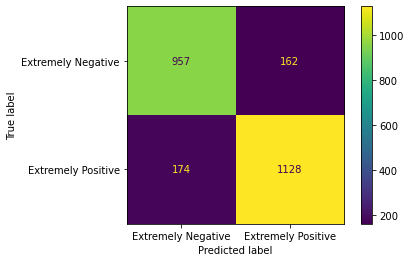

In [18]:
get_accuracy(nn_model2,tweet_test_tfidf,sentiment_test)